# Pix2Pix

- Theory: [A Gentle Introduction to Pix2Pix Generative Adversarial Network](https://machinelearningmastery.com/a-gentle-introduction-to-pix2pix-generative-adversarial-network/)
- Step-by-step implementation: [How to Implement Pix2Pix GAN Models From Scratch With Keras](https://machinelearningmastery.com/how-to-implement-pix2pix-gan-models-from-scratch-with-keras/)
- All together: [How to Develop a Pix2Pix GAN for Image-to-Image Translation](https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/)

The Pix2Pix Generative Adversarial Network, or GAN, is an approach to training a deep convolutional neural network for image-to-image translation tasks.

The careful configuration of architecture as a type of image-conditional GAN allows for both the generation of large images compared to prior GAN models (e.g. such as 256×256 pixels) and the capability of performing well on a variety of different image-to-image translation tasks.

In this tutorial, you will discover how to develop a Pix2Pix generative adversarial network for image-to-image translation.

## After completing this tutorial, you will know:

How to load and prepare the satellite image to Google maps image-to-image translation dataset.
How to develop a Pix2Pix model for translating satellite photographs to Google map images.
How to use the final Pix2Pix generator model to translate ad hoc satellite images.

# Tutorial Overview
This tutorial is divided into five parts; they are:

- What Is the Pix2Pix GAN?
- Satellite to Map Image Translation Dataset
- How to Develop and Train a Pix2Pix Model
- How to Translate Images With a Pix2Pix Model
- How to Translate Google Maps to Satellite Images


# What Is the Pix2Pix GAN?
Pix2Pix is a Generative Adversarial Network, or GAN, model designed for general purpose image-to-image translation.

The approach was presented by Phillip Isola, et al. in their 2016 paper titled “Image-to-Image Translation with Conditional Adversarial Networks” and presented at CVPR in 2017.

The GAN architecture is comprised of a generator model for outputting new plausible synthetic images, and a discriminator model that classifies images as real (from the dataset) or fake (generated). The discriminator model is updated directly, whereas the generator model is updated via the discriminator model. As such, the two models are trained simultaneously in an adversarial process where the generator seeks to better fool the discriminator and the discriminator seeks to better identify the counterfeit images.

The Pix2Pix model is a type of conditional GAN, or cGAN, where the generation of the output image is conditional on an input, in this case, a source image. The discriminator is provided both with a source image and the target image and must determine whether the target is a plausible transformation of the source image.

The generator is trained via adversarial loss, which encourages the generator to generate plausible images in the target domain. The generator is also updated via L1 loss measured between the generated image and the expected output image. This additional loss encourages the generator model to create plausible translations of the source image.

The Pix2Pix GAN has been demonstrated on a range of image-to-image translation tasks such as converting maps to satellite photographs, black and white photographs to color, and sketches of products to product photographs.

Now that we are familiar with the Pix2Pix GAN, let’s prepare a dataset that we can use with image-to-image translation.



# Data

In [54]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

--2019-09-12 09:22:30--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz.2’

maps.tar.gz.2       100%[===================>] 238.65M  1.73MB/s    in 2m 35s  

2019-09-12 09:25:04 (1.54 MB/s) - ‘maps.tar.gz.2’ saved [250242400/250242400]



In [55]:

!tar -xvf maps.tar.gz

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/531.jpg
maps/train/532.jpg
maps/train/533.jpg
maps/train/534.jpg
maps/train/535.jpg
maps/train/536.jpg
maps/train/537.jpg
maps/train/538.jpg
maps/train/539.jpg
maps/train/54.jpg
maps/train/540.jpg
maps/train/541.jpg
maps/train/542.jpg
maps/train/543.jpg
maps/train/544.jpg
maps/train/545.jpg
maps/train/546.jpg
maps/train/547.jpg
maps/train/548.jpg
maps/train/549.jpg
maps/train/55.jpg
maps/train/550.jpg
maps/train/551.jpg
maps/train/552.jpg
maps/train/553.jpg
maps/train/554.jpg
maps/train/555.jpg
maps/train/556.jpg
maps/train/557.jpg
maps/train/558.jpg
ma

The train folder contains 1,097 images, whereas the validation dataset contains 1,099 images.

Images have a digit filename and are in JPEG format. 
__Each image is 1,200 pixels wide and 600 pixels tall and contains both the satellite image on the left and the Google maps image on the right.__

We can prepare this dataset for training a Pix2Pix GAN model in Keras. We will just work with the images in the training dataset. Each image will be loaded, rescaled, and split into the satellite and Google map elements. The result will be 1,097 color image pairs with the width and height of 256×256 pixels.

The load_images() function below implements this. It enumerates the list of images in a given directory, loads each with the target size of 256×512 pixels, splits each image into satellite and map elements and returns an array of each.

We can call this function with the path to the training dataset. Once loaded, we can save the prepared arrays to a new file in compressed format for later use.

The complete example is listed below.

In [56]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
 
# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]
 
# dataset path
path = 'maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


This file can be loaded later via the load() NumPy function and retrieving each array in turn.

We can then plot some images pairs to confirm the data has been handled correctly.

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


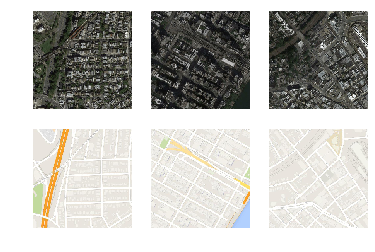

In [57]:

# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the face dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

# How to Develop and Train a Pix2Pix Model
In this section, we will develop the Pix2Pix model for translating satellite photos to Google maps images.

The same model architecture and configuration described in the paper was used across a range of image translation tasks. This architecture is both described in the body of the paper, with additional detail in the appendix of the paper, and a fully working implementation provided as open source with the Torch deep learning framework.

The implementation in this section will use the Keras deep learning framework based directly on the model described in the paper and implemented in the author’s code base, designed to take and generate color images with the size 256×256 pixels.

The architecture is comprised of two models: the discriminator and the generator.

# Discriminator
The discriminator is a deep convolutional neural network that performs image classification. Specifically, conditional-image classification. It takes both the source image (e.g. satellite photo) and the target image (e.g. Google maps image) as input and predicts the likelihood of whether target image is real or a fake translation of the source image.

The discriminator design is based on the effective receptive field of the model, which defines the relationship between one output of the model to the number of pixels in the input image. This is called a PatchGAN model and is carefully designed so that each output prediction of the model maps to a 70×70 square or patch of the input image. The benefit of this approach is that the same model can be applied to input images of different sizes, e.g. larger or smaller than 256×256 pixels.

The output of the model depends on the size of the input image but may be one value or a square activation map of values. Each value is a probability for the likelihood that a patch in the input image is real. These values can be averaged to give an overall likelihood or classification score if needed.

The define_discriminator() function below implements the 70×70 PatchGAN discriminator model as per the design of the model in the paper. The model takes two input images that are concatenated together and predicts a patch output of predictions. The final output is 16x16, since the stride=(2,2) divides the size by 2 although padding=same.

The model is optimized using binary cross entropy, and a weighting is used so that updates to the model have half (0.5) the usual effect. The authors of Pix2Pix recommend this weighting of model updates to slow down changes to the discriminator, relative to the generator model during training.

In [0]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

In [0]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [0]:
d_model = define_discriminator((256,256,3))


# Generator
The generator model is more complex than the discriminator model.

The generator is an encoder-decoder model using a U-Net architecture. The model takes a source image (e.g. satellite photo) and generates a target image (e.g. Google maps image). It does this by first downsampling or encoding the input image down to a bottleneck layer, then upsampling or decoding the bottleneck representation to the size of the output image. The U-Net architecture means that skip-connections are added between the encoding layers and the corresponding decoding layers, forming a U-shape.

The encoder and decoder of the generator are comprised of standardized blocks of convolutional, batch normalization, dropout, and activation layers. This standardization means that we can develop helper functions to create each block of layers and call it repeatedly to build-up the encoder and decoder parts of the model.

The define_generator() function below implements the U-Net encoder-decoder generator model. It uses the define_encoder_block() helper function to create blocks of layers for the encoder and the decoder_block() function to create blocks of layers for the decoder. The tanh activation function is used in the output layer, meaning that pixel values in the generated image will be in the range [-1,1].

A better implementation is using Upsampling2D, but we will live with the Conv2DTranspose for the tutorial.



In [0]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

The discriminator model is trained directly on real and generated images, whereas the generator model is not.

Instead, the generator model is trained via the discriminator model. It is updated to minimize the loss predicted by the discriminator for generated images marked as “real.” As such, it is encouraged to generate more real images. The generator is also updated to minimize the L1 loss or mean absolute error between the generated image and the target image.

The generator is updated via a weighted sum of both the adversarial loss and the L1 loss, where the authors of the model recommend a weighting of 100 to 1 in favor of the L1 loss. This is to encourage the generator strongly toward generating plausible translations of the input image, and not just plausible images in the target domain.

This can be achieved by defining a new logical model comprised of the weights in the existing standalone generator and discriminator model. This logical or composite model involves stacking the generator on top of the discriminator. A source image is provided as input to the generator and to the discriminator, although the output of the generator is connected to the discriminator as the corresponding “target” image. The discriminator then predicts the likelihood that the generator was a real translation of the source image.

The discriminator is updated in a standalone manner, so the weights are reused in this composite model but are marked as not trainable. The composite model is updated with two targets, one indicating that the generated images were real (cross entropy loss), forcing large weight updates in the generator toward generating more realistic images, and the executed real translation of the image, which is compared against the output of the generator model (L1 loss).

The define_gan() function below implements this, taking the already-defined generator and discriminator models as arguments and using the Keras functional API to connect them together into a composite model. Both loss functions are specified for the two outputs of the model and the weights used for each are specified in the loss_weights argument to the compile() function.

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

Next, we can load our paired images dataset in compressed NumPy array format.

This will return a list of two NumPy arrays: the first for source images and the second for corresponding target images.

In [0]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

Training the discriminator will require batches of real and fake images.

The generate_real_samples() function below will prepare a batch of random pairs of images from the training dataset, and the corresponding discriminator label of class=1 to indicate they are real.

In [0]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

The generate_fake_samples() function below uses the generator model and a batch of real source images to generate an equivalent batch of target images for the discriminator.

These are returned with the label class-0 to indicate to the discriminator that they are fake.

In [0]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# How to evaluate?
Typically, GAN models do not converge; instead, an equilibrium is found between the generator and discriminator models. As such, we cannot easily judge when training should stop. Therefore, we can save the model and use it to generate sample image-to-image translations periodically during training, such as every 10 training epochs.

The summarize_performance() function implements this, taking the generator model at a point during training and using it to generate a number, in this case three, of translations of randomly selected images in the dataset. The source, generated image, and expected target are then plotted as three rows of images and the plot saved to file. Additionally, the model is saved to an H5 formatted file that makes it easier to load later.

Both the image and model filenames include the training iteration number, allowing us to easily tell them apart at the end of training.

In [0]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# Train the model
Finally, we can train the generator and discriminator models.

The train() function below implements this, taking the defined generator, discriminator, composite model, and loaded dataset as input. The number of epochs is set at 100 to keep training times down, although 200 was used in the paper. A batch size of 1 is used as is recommended in the paper.

Training involves a fixed number of training iterations. There are 1,097 images in the training dataset. One epoch is one iteration through this number of examples, with a batch size of one means 1,097 training steps. The generator is saved and evaluated every 10 epochs or every 10,097 training steps, and the model will run for 100 epochs, or a total of 100,097 training steps.

Each training step involves first selecting a batch of real examples, then using the generator to generate a batch of matching fake samples using the real source images. The discriminator is then updated with the batch of real images and then fake images.

Next, the generator model is updated providing the real source images as input and providing class labels of 1 (real) and the real target images as the expected outputs of the model required for calculating loss. The generator has two loss scores as well as the weighted sum score returned from the call to train_on_batch(). We are only interested in the weighted sum score (the first value returned) as it is used to update the model weights.

Finally, the loss for each update is reported to the console each training iteration and model performance is evaluated every 10 training epochs.

In [0]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, dataset)

In [68]:
# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1[0.436] d2[0.627] g[62.335]
>2, d1[0.363] d2[0.539] g[59.822]
>3, d1[0.365] d2[0.534] g[77.554]
>4, d1[0.371] d2[0.437] g[73.012]
>5, d1[0.365] d2[0.393] g[71.740]
>6, d1[0.480] d2[0.455] g[62.379]
>7, d1[0.354] d2[0.394] g[65.312]
>8, d1[0.239] d2[0.399] g[39.431]
>9, d1[0.308] d2[0.419] g[45.089]
>10, d1[0.239] d2[0.277] g[58.304]
>11, d1[0.370] d2[0.270] g[39.660]
>12, d1[0.160] d2[0.194] g[51.403]
>13, d1[0.136] d2[0.216] g[51.630]
>14, d1[0.124] d2[0.142] g[47.390]
>15, d1[0.143] d2[0.171] g[45.919]
>16, d1[0.229] d2[0.233] g[40.236]
>17, d1[0.059] d2[0.105] g[40.621]
>18, d1[0.136] d2[0.064] g[40.031]
>19, d1[0.050] d2[0.144] g[39.108]
>20, d1[0.027] d2[0.057] g[33.502]
>21, d1[1.876] d2[0.129] g[23.766]
>22, d1[0.034] d2[0.330] g[29.171]
>23, d1[1.194] d2[0.656] g[25.348]
>24, d1[0.417] d2[0.304] g[23.017]
>25, d1[0.337] d2[1.417] g[22.140]
>26, d1[0.323] d2[0.163] g[23.392]
>27, d1[0.865] d2[0.603] g[21.621]
>28, d1[0.553] d2[0.646] g[20.126]
>29, d1[0.389] d2[0.521] g[19

The example can be run on CPU hardware, although GPU hardware is recommended.

The example might take about two hours to run on modern GPU hardware.

Note: your specific results may vary given the stochastic nature of the learning algorithm. Consider running the example a few times.

The loss is reported each training iteration, including the discriminator loss on real examples (d1), discriminator loss on generated or fake examples (d2), and generator loss, which is a weighted average of adversarial and L1 loss (g).

If loss for the discriminator goes to zero and stays there for a long time, consider re-starting the training run as it is an example of a training failure.

Models are saved every 10 epochs and saved to a file with the training iteration number. Additionally, images are generated every 10 epochs and compared to the expected target images. These plots can be assessed at the end of the run and used to select a final generator model based on generated image quality.

At the end of the run, will you will have 10 saved model files and 10 plots of generated images.

After the first 10 epochs, map images are generated that look plausible, although the lines for streets are not entirely straight and images contain some blurring. Nevertheless, large structures are in the right places with mostly the right colors.

# How to Translate Images With a Pix2Pix Model?

Training the Pix2Pix model results in many saved models and samples of generated images for each.

More training epochs does not necessarily mean a better quality model. Therefore, we can choose a model based on the quality of the generated images and use it to perform ad hoc image-to-image translation.

In this case, we will use the model saved at the end of the run, e.g. after 10 epochs or 109,600 training iterations.

A good starting point is to load the model and use it to make ad hoc translations of source images in the training dataset.

First, we can load the training dataset. We can use the same function named load_real_samples() for loading the dataset as was used when training the model.

In [0]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed ararys
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]



In [70]:

# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


In [0]:
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


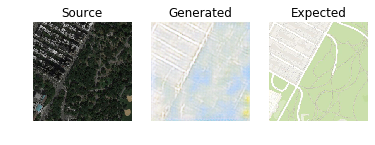

In [72]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint



# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('model_001096.h5')
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

# How to Translate Google Maps to Satellite Images?
Now that we are familiar with how to develop and use a Pix2Pix model for translating satellite images to Google maps, we can also explore the reverse.

That is, we can develop a Pix2Pix model to translate Google map images to plausible satellite images. This requires that the model invent or hallucinate plausible buildings, roads, parks, and more.

We can use the same code to train the model with one small difference. We can change the order of the datasets returned from the load_real_samples() function; for example:


In [0]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	# return in reverse order
	return [X2, X1]

Note: the order of X1 and X2 is reversed.

This means that the model will take Google map images as input and learn to generate satellite images.

Run the example as before.

Note: your specific results may vary given the stochastic nature of the learning algorithm. Consider running the example a few times.

As before, the loss of the model is reported each training iteration. If loss for the discriminator goes to zero and stays there for a long time, consider re-starting the training run as it is an example of a training failure.

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


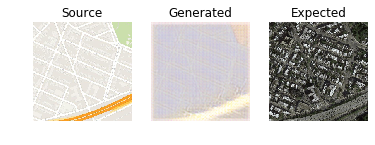

In [74]:
# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)

# load model
model = load_model('model_001096.h5')


# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = model.predict(src_image)


# plot all three images
plot_images(src_image, gen_image, tar_image)
